## Homework 3 - Om Gaikwad

### Step 1: Data Acquisition

Train images shape: (60000, 28, 28)
Train labels shape: (60000,)
Test images shape: (10000, 28, 28)
Test labels shape: (10000,)


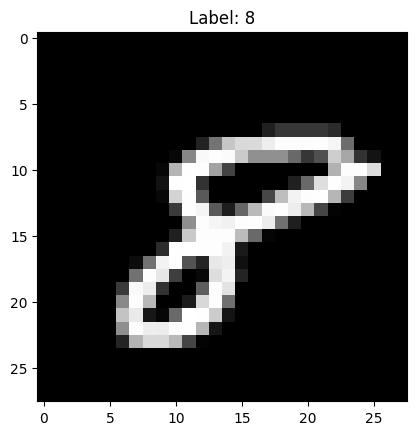

In [28]:
import numpy as np
import matplotlib.pyplot as plt
import gzip, struct, os


def read_idx(filename):
    with gzip.open(filename, 'rb') as f:
        zero, data_type, dims = struct.unpack('>HBB', f.read(4))
        shape = tuple(struct.unpack('>I', f.read(4))[0] for d in range(dims))
        return np.frombuffer(f.read(), dtype=np.uint8).reshape(shape)

X_train = read_idx("MNIST/train-images-idx3-ubyte.gz")
y_train = read_idx("MNIST/train-labels-idx1-ubyte.gz")
X_test = read_idx("MNIST/t10k-images-idx3-ubyte.gz")    
y_test = read_idx("MNIST/t10k-labels-idx1-ubyte.gz")

print("Train images shape:", X_train.shape)
print("Train labels shape:", y_train.shape)
print("Test images shape:", X_test.shape)
print("Test labels shape:", y_test.shape)

# visualize a sample
idx = np.random.randint(0, X_train.shape[0])
plt.imshow(X_train[idx], cmap='gray')
plt.title(f"Label: {y_train[idx]}")
plt.show()

### Step 2: Data Processing

In [29]:
# Normalize the pixel values to be between 0 and 1
X_train = X_train / 255.0
X_test = X_test / 255.0

# Flatten the images into 1D vectors
X_train = X_train.reshape(-1, 28*28)
X_test = X_test.reshape(-1, 28*28)

# One-hot encode the labels
def one_hot_encode(y, num_classes=10):
    return np.eye(num_classes)[y]

y_train_encoded = one_hot_encode(y_train)
y_test_encoded = one_hot_encode(y_test)

### Step 3: Network Initialization


In [30]:
# Sigmoid function
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def sigmoid_derivative(x):
    s = sigmoid(x)
    return s * (1 - s)

def softmax(x):
    exps = np.exp(x - np.max(x, axis=1, keepdims=True))
    return exps / np.sum(exps, axis=1, keepdims=True)

np.random.seed(595)
input_size = 784
hidden1 = 128
hidden2 = 64
output_size = 10

W1 = np.random.randn(input_size, hidden1) * 0.01
b1 = np.zeros((1, hidden1))
W2 = np.random.randn(hidden1, hidden2) * 0.01
b2 = np.zeros((1, hidden2))
W3 = np.random.randn(hidden2, output_size) * 0.01
b3 = np.zeros((1, output_size))

### Step 4: Feed Forward

In [31]:
def feed_forward(x):
    z1 = np.dot(x, W1) + b1
    a1 = sigmoid(z1)
    z2 = np.dot(a1, W2) + b2
    a2 = sigmoid(z2)
    z3 = np.dot(a2, W3) + b3
    a3 = softmax(z3)
    return z1, a1, z2, a2, z3, a3

### Step 5: Back Propagation

In [32]:
# Compute the loss
def categorical_crossentropy(y_true, y_pred):
    n_samples = y_true.shape[0]
    y_pred_clipped = np.clip(y_pred, 1e-12, 1-1e-12)
    return -np.sum(y_true * np.log(y_pred_clipped)) / n_samples


def back_propagation(x, y_true, z1, a1, z2, a2, z3, a3):
    m = y_true.shape[0]
    
    # Compute the gradient of the loss w.r.t the output layer
    dz3 = a3 - y_true
    dW3 = np.dot(a2.T, dz3) / m
    db3 = np.sum(dz3, axis=0, keepdims=True) / m

    # Compute the gradient of the loss w.r.t the hidden layer 2
    dz2 = np.dot(dz3, W3.T) * sigmoid_derivative(z2)
    dW2 = np.dot(a1.T, dz2) / m
    db2 = np.sum(dz2, axis=0, keepdims=True) / m

    # Compute the gradient of the loss w.r.t the hidden layer 1
    dz1 = np.dot(dz2, W2.T) * sigmoid_derivative(z1)
    dW1 = np.dot(x.T, dz1) / m
    db1 = np.sum(dz1, axis=0, keepdims=True) / m

    return dW1, db1, dW2, db2, dW3, db3


### Step 6: Model Training

In [33]:
learning_rate = 0.1
batch_size = 128
epochs = 100
loss_log = []

for epoch in range(epochs):
    permutation = np.random.permutation(X_train.shape[0])
    X_shuffled = X_train[permutation]
    y_shuffled = y_train_encoded[permutation]
    n_batches = X_train.shape[0] // batch_size

    for i in range(n_batches):
        start = i * batch_size
        end = start + batch_size
        x_batch = X_shuffled[start:end]
        y_batch = y_shuffled[start:end]

        z1, a1, z2, a2, z3, a3 = feed_forward(x_batch)
        dW1, db1, dW2, db2, dW3, db3 = back_propagation(x_batch, y_batch, z1, a1, z2, a2, z3, a3)

        W1 -= learning_rate * dW1
        b1 -= learning_rate * db1
        W2 -= learning_rate * dW2
        b2 -= learning_rate * db2
        W3 -= learning_rate * dW3
        b3 -= learning_rate * db3

    # compute training loss and test accuracy at end of each epoch
    z1_train, a1_train, z2_train, a2_train, z3_train, train_pred = feed_forward(X_train)
    loss = categorical_crossentropy(y_train_encoded, train_pred)
    loss_log.append(loss)
    z1_test, a1_test, z2_test, a2_test, z3_test, test_pred = feed_forward(X_test)
    test_acc = np.mean(np.argmax(test_pred, axis=1) == y_test)
    print(f"Epoch {epoch+1}: Loss = {loss:.4f}, Test Accuracy = {test_acc:.4f}")

Epoch 1: Loss = 2.3039, Test Accuracy = 0.1135
Epoch 2: Loss = 2.3045, Test Accuracy = 0.1028
Epoch 3: Loss = 2.3045, Test Accuracy = 0.1032
Epoch 4: Loss = 2.3020, Test Accuracy = 0.1135
Epoch 5: Loss = 2.3025, Test Accuracy = 0.1934
Epoch 6: Loss = 2.2952, Test Accuracy = 0.1271
Epoch 7: Loss = 2.0661, Test Accuracy = 0.2602
Epoch 8: Loss = 1.7215, Test Accuracy = 0.3501
Epoch 9: Loss = 1.2673, Test Accuracy = 0.5163
Epoch 10: Loss = 1.0851, Test Accuracy = 0.6114
Epoch 11: Loss = 0.9423, Test Accuracy = 0.6848
Epoch 12: Loss = 0.8043, Test Accuracy = 0.7515
Epoch 13: Loss = 0.6827, Test Accuracy = 0.8019
Epoch 14: Loss = 0.5925, Test Accuracy = 0.8348
Epoch 15: Loss = 0.5298, Test Accuracy = 0.8535
Epoch 16: Loss = 0.4743, Test Accuracy = 0.8719
Epoch 17: Loss = 0.4354, Test Accuracy = 0.8806
Epoch 18: Loss = 0.4002, Test Accuracy = 0.8923
Epoch 19: Loss = 0.3662, Test Accuracy = 0.9008
Epoch 20: Loss = 0.3386, Test Accuracy = 0.9079
Epoch 21: Loss = 0.3166, Test Accuracy = 0.9143
E

### Step 7: Model Evaluation

Test Accuracy: 0.975


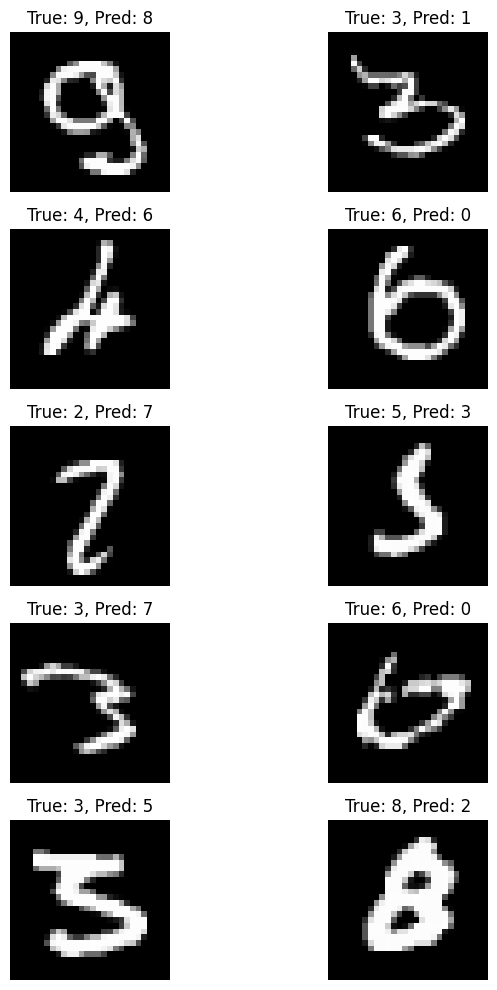

In [35]:
# Compute the test accuracy
z1_test, a1_test, z2_test, a2_test, z3_test, y_pred_test = feed_forward(X_test)
pred_labels = np.argmax(y_pred_test, axis=1)
true_labels = y_test
accuracy = np.mean(pred_labels == true_labels)
print("Test Accuracy:", accuracy)

# Plot misclassified images
wrong_idx = np.where(pred_labels != true_labels)[0][:10]
fig, axs = plt.subplots(nrows=5, ncols=2, figsize=(8, 10))
axs = axs.flatten()

for i, ax in enumerate(axs):
    idx = wrong_idx[i]
    ax.imshow(X_test[idx].reshape(28, 28), cmap='gray')
    ax.set_title(f"True: {true_labels[idx]}, Pred: {pred_labels[idx]}")
    ax.axis('off')

plt.tight_layout()
plt.show()